In [26]:
import pandas as pd
import plotnine as pn

In [27]:
# Constants 
params = [
    0, 1, 2, 4, 8, 16,
]

num_states = 10
num_signals = 10
prior_type = "uniform" # random
dynamics = "replicator_dynamic" # noisy
num_trials = 8 # 6

In [28]:
# Filepaths

# TODO: use hydra interpolation, not absolute paths!

#############################################################################
# Analysis files
#############################################################################

# Pareto frontier
curve_fn = f"/Users/nathanielimel/uci/projects/rdsg/outputs/states={num_states}/signals={num_signals}/distortion=squared_dist/prior={prior_type}/curve_points.csv"

# Counterpart points
counterpart_fn = f"/Users/nathanielimel/uci/projects/rdsg/outputs/states={num_states}/signals={num_signals}/distortion=squared_dist/prior={prior_type}/counterpart_points.csv"

#############################################################################
# Simulation points
#############################################################################


sim_fns = {
    f"{float(param)}":f"/Users/nathanielimel/uci/projects/rdsg/multirun/states={num_states}/signals={num_signals}/distortion=squared_dist/prior={prior_type}/similarity=nosofsky_normed/dynamics={dynamics}/num_trials={num_trials}/sim_param={param}/simulation_points.csv"
    for param in params
}

traj_fns = {
    key: val.replace("simulation_points", "mean_points") for key, val in sim_fns.items()
}

variant_fns = {
    key: val.replace("simulation_points", "variant_points") for key, val in sim_fns.items()
}


In [29]:
# load dataframes
curve_data = pd.read_csv(curve_fn)
counterpart_final_data = pd.read_csv(counterpart_fn)

sim_dfs = {k: pd.read_csv(sim_fns[k]) for k in sim_fns}
trajs_dfs = {k: pd.read_csv(traj_fns[k]) for k in traj_fns}
variant_dfs = {k: pd.read_csv(variant_fns[k])for k in variant_fns}

In [30]:
sim = "single_trial"
traj = "trajectory"
var = "variant"
ba = "blahut_arimoto"

# label each df to be concatenated with a columns
def concat_with_columns(dfs: dict[str, pd.DataFrame], point_type: str, dynamic: str) -> pd.DataFrame:
    # add alpha for each dataframe
    for key in dfs:
        df = dfs[key]
        df["alpha"] = key # use string for category

    df = pd.concat(dfs.values())

    # annotate simulation-level info
    df["point_type"] = point_type
    df["dynamic"] = dynamic
    return df


# handle counterpart differently

counterpart_final_data["point_type"] = sim
counterpart_final_data["dynamic"] = ba

sim_data = concat_with_columns(sim_dfs, sim, dynamics)
traj_data = concat_with_columns(trajs_dfs, traj, dynamics)
variant_data = concat_with_columns(variant_dfs, var, dynamics)

In [31]:
# concatenate all simulation-related (e.g. NOT sampled) data into one dataframe
data = pd.concat([
    counterpart_final_data,
    sim_data, 
    traj_data,
    variant_data,
]).reset_index()
data

,index,rate,distortion,beta,alpha,point_type,dynamic
0,0,3.321928,0.000000,1000.000000,0.0,single_trial,blahut_arimoto
1,1,1.861867,0.485263,1.000000,1.0,single_trial,blahut_arimoto
2,2,0.963131,1.822883,0.250000,2.0,single_trial,blahut_arimoto
3,3,0.057531,7.616357,0.062500,4.0,single_trial,blahut_arimoto
4,4,0.001560,8.380513,0.015625,8.0,single_trial,blahut_arimoto
...,...,...,...,...,...,...,...
6049,995,0.475055,10.324689,NaN,16.0,variant,replicator_dynamic
6050,996,0.688621,20.637394,NaN,16.0,variant,replicator_dynamic
6051,997,0.418359,11.653662,NaN,16.0,variant,replicator_dynamic
6052,998,0.642198,19.928182,NaN,16.0,variant,replicator_dynamic


In [32]:
# let alpha just be integer valued (and then string valued for categorical var)
data["alpha"] = data["alpha"].astype(float)
data["alpha"] = data["alpha"].astype(int)
data["alpha"] = data["alpha"].astype(str)

data = data.assign(
    alpha=pd.Categorical(
        data["alpha"],
        categories=[str(param) for param in params]
    )
)
data # N.B.: nans are expected for 'round' column

,index,rate,distortion,beta,alpha,point_type,dynamic
0,0,3.321928,0.000000,1000.000000,0,single_trial,blahut_arimoto
1,1,1.861867,0.485263,1.000000,1,single_trial,blahut_arimoto
2,2,0.963131,1.822883,0.250000,2,single_trial,blahut_arimoto
3,3,0.057531,7.616357,0.062500,4,single_trial,blahut_arimoto
4,4,0.001560,8.380513,0.015625,8,single_trial,blahut_arimoto
...,...,...,...,...,...,...,...
6049,995,0.475055,10.324689,NaN,16,variant,replicator_dynamic
6050,996,0.688621,20.637394,NaN,16,variant,replicator_dynamic
6051,997,0.418359,11.653662,NaN,16,variant,replicator_dynamic
6052,998,0.642198,19.928182,NaN,16,variant,replicator_dynamic


In [33]:
points = data[data["dynamic"] == dynamics]
emergent = points[points["point_type"] == sim]
variants = points[points["point_type"] == var]

emergent["language"] = "emergent"
variants["language"] = "hypothetical"

/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_66514/3593370370.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_66514/3593370370.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [34]:
# extract the trajectory data
trajs = points[points["point_type"] == traj]

# including 'counterparts' from B-A optimization
counterpart_data = data[data["dynamic"] == "blahut_arimoto"]
# set the language column for counterparts
counterpart_data["language"] = "optimal \ncounterpart"
counterpart_points = counterpart_data[counterpart_data["point_type"] == sim]
counterpart_trajs = counterpart_data[counterpart_data["point_type"] == traj]

# set the final rounds
# final_round_data = trajs[trajs["round"] == trajs["round"].max()]
counterpart_final_round_data = counterpart_trajs[counterpart_trajs["round"] == counterpart_trajs["round"].max()]

# each simulation may have ended after a different number of rounds
final_round_dfs = []
for alpha in trajs["alpha"]:
    subset = trajs[trajs["alpha"] == alpha]
    round_max = subset["round"].max()
    final_round_dfs.append(subset[subset["round"] == round_max])
final_round_data = pd.concat(final_round_dfs)

final_round_data["language"] = "emergent"

display(trajs)
display(final_round_data)

/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_66514/2169919907.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


KeyError: 'round'

In [ ]:
# Define a float-valued column in data to get color scale, called "imprecision"

def add_imprecision_column(df):
    df["imprecision"] = df["alpha"]

[add_imprecision_column(df) for df in [emergent, trajs, final_round_data]]
add_imprecision_column(counterpart_points)

/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_94307/231451002.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_94307/231451002.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


/Users/nathanielimel/miniforge3/envs/rdsg/lib/python3.10/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_point : Removed 1388 rows containing missing values.


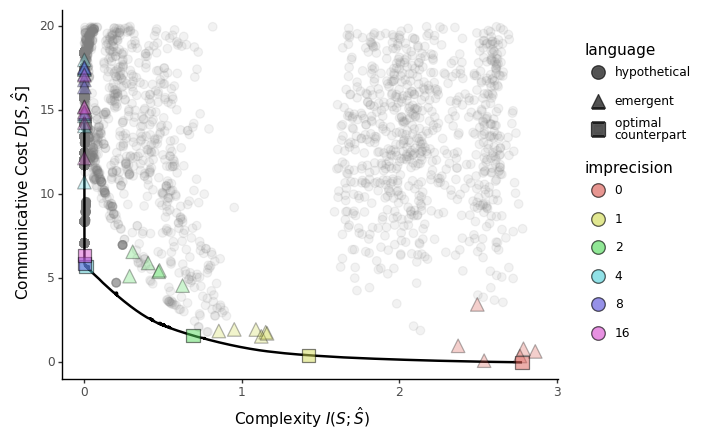

In [ ]:
plot_sim = (
    # Set data and the axes
    pn.ggplot(
        data=curve_data, mapping=pn.aes(x="rate", y="distortion")
    )  
    + pn.geom_point(  # hypothetical langs
        data=variants,
        mapping=pn.aes(shape="language"),
        color="gray",
        size=3,
        alpha=0.1,
    )
    + pn.geom_line(size=1) # pareto data
    + pn.geom_jitter( # emergent langs
        data=emergent,
        mapping=pn.aes(
            fill="imprecision",
            shape="language",
            ),
        alpha=0.3,
        size=5,
    )        
    + pn.geom_point( # theoretical bound langs
        data=counterpart_points,
        mapping=pn.aes(
            fill="imprecision",
            shape="language",
            ),
        alpha=0.5,
        size=5,
    )
    + pn.xlab("Complexity $I(S;\hat{S})$")
    + pn.ylab("Communicative Cost $D[S, \hat{S}]$")
    # + pn.ylim(0, 20)
    + pn.theme_classic()
)
print(plot_sim)

/Users/nathanielimel/miniforge3/envs/rdsg/lib/python3.10/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_point : Removed 1388 rows containing missing values.


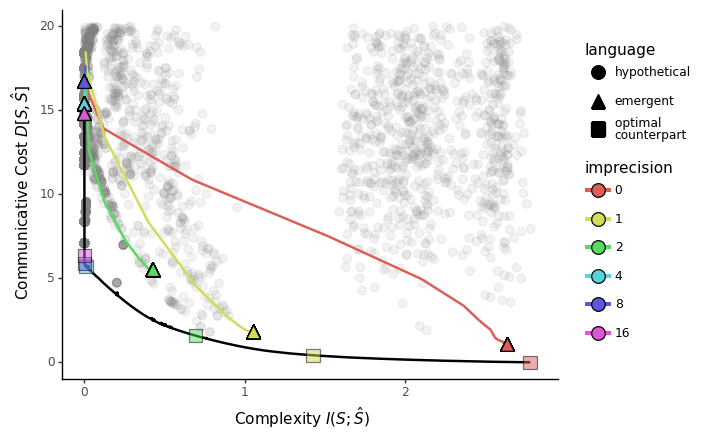

In [ ]:
plot_traj = (
    # Set data and the axes
    pn.ggplot(
        data=curve_data, mapping=pn.aes(x="rate", y="distortion")
    )  
    + pn.geom_point(
        data=variants,
        mapping=pn.aes(shape="language"),
        color="gray",
        size=3,
        alpha=0.1,
    )
    + pn.geom_line(  # simulation langs
        data=trajs,
        mapping=pn.aes(color="imprecision"),
        alpha=1.0,
        size=1,
    )
    + pn.geom_line(size=1) # pareto     
    + pn.geom_point(  # final langs
        data=final_round_data,
        mapping=pn.aes(fill="imprecision", shape="language"),
        # shape="X",
        size=5,
    )          
    + pn.geom_point( # theoretical bound langs
        data=counterpart_points,
        mapping=pn.aes(
            fill="imprecision",
            shape="language",
            ),
        alpha=0.5,
        size=5,
    )    
    + pn.xlab("Complexity $I(S;\hat{S})$")
    + pn.ylab("Communicative Cost $D[S, \hat{S}]$")
    # + pn.ylim(0, 20)
    + pn.theme_classic()
)
print(plot_traj)